In [30]:
import pandas as pd

In [31]:
from fastai.vision.all import *
import warnings
warnings.filterwarnings('ignore')

In [32]:
path = Path('/kaggle/input/plantdisease/PlantVillage')
print(path.ls()[:2])  # check a few folders


[Path('/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot'), Path('/kaggle/input/plantdisease/PlantVillage/Potato___healthy')]


In [33]:
path.ls()[1]

Path('/kaggle/input/plantdisease/PlantVillage/Potato___healthy')

In [34]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)



1.get_items:
It automatically searches recursively (through subfolders).
It filters only image files.
Works perfectly when your dataset is organized by folders (one folder per class).

2.get_y tells Fast.ai how to get the label (target) for each input image.



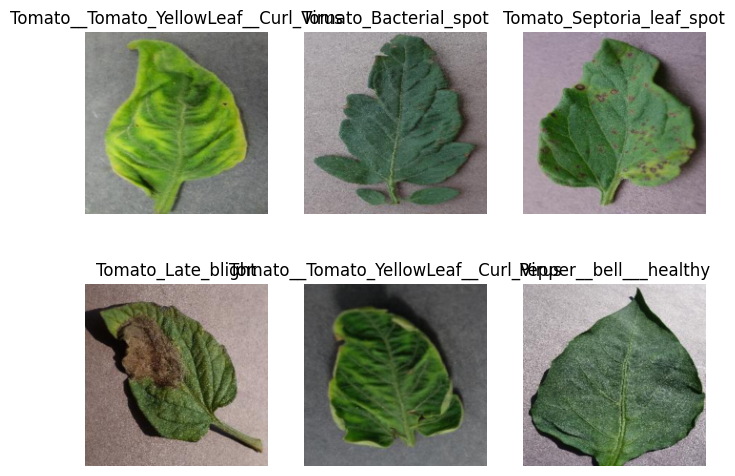

In [35]:
dls.show_batch(max_n=6, figsize=(8,6))


In [36]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)


epoch,train_loss,valid_loss,error_rate,time
0,0.515082,0.283170,0.092803,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.178778,0.109153,0.032954,00:44
1,0.085047,0.051573,0.018658,00:45
2,0.020577,0.028838,0.009692,00:44


metrics : error_rate is a built-in evaluation metric that measures how often the model predicts incorrectly.
Error Rate=1−Accuracy
So if my model correctly classifies 98 out of 100 images:
Error Rate=1−0.98=0.02 (2% error rate)

In [37]:
def error_rate(inp, targ):
    return (inp.argmax(dim=-1) != targ).float().mean()

##inp is logit score which are Raw model scores per class

argmax(dim=-1) → get predicted class index
Compare with true label targs
Take mean of wrong predictions → gives error_rate

Error rate: 0.0097


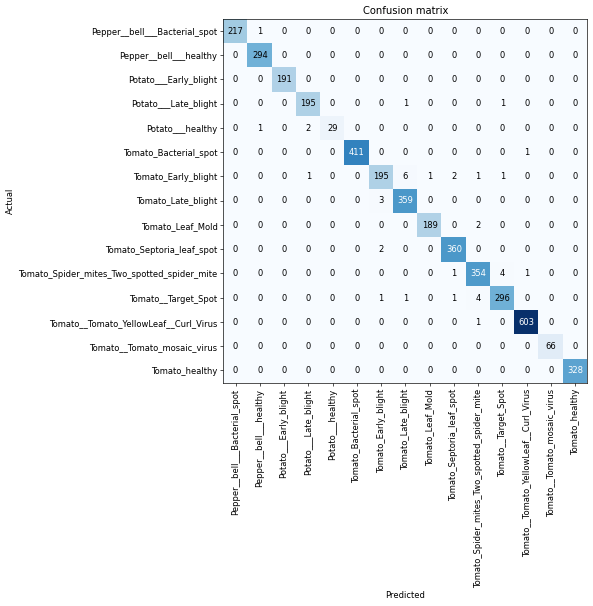

In [38]:
# Evaluate error rate and accuracy on validation set
error_rate_val = learn.validate()[1] # Second element (index 1) of the validation results — which is the error rate — and store it in the variable error_rate_val.”
print(f"Error rate: {error_rate_val:.4f}")

# Show top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)


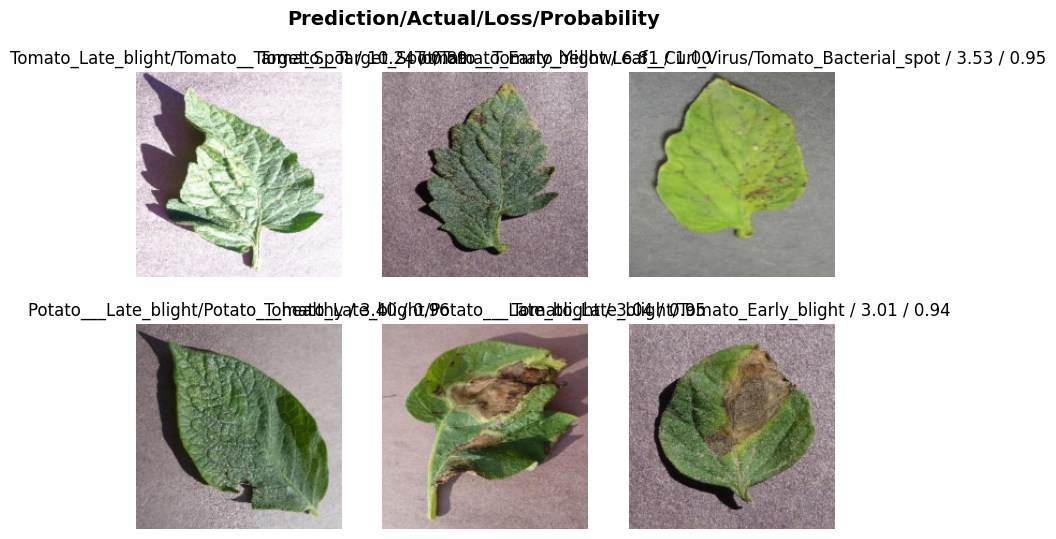

In [39]:
interp.plot_top_losses(6, nrows=2)



In [40]:
# 5️⃣ Prediction
img = PILImage.create('/kaggle/input/leafss/pepper_leaf.jpeg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Confidence: {probs[pred_idx]*100:.2f}%")


Prediction: Pepper__bell___healthy, Confidence: 99.96%


In [41]:
# 5️⃣ Prediction
img = PILImage.create('/kaggle/input/bjbkbkbkb/bacterialspotontomatoXant (1).jpeg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Confidence: {probs[pred_idx]*100:.2f}%")


Prediction: Tomato_Septoria_leaf_spot, Confidence: 97.41%


In [42]:
## Trying batch_tfms For Even Better Accuracy
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=15, max_zoom=1.1)
).dataloaders(path, bs=32)


In [43]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)


epoch,train_loss,valid_loss,error_rate,time
0,0.591986,0.368141,0.122607,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.267076,0.149204,0.048946,00:54
1,0.125241,0.061326,0.021323,00:55
2,0.081143,0.040910,0.015023,00:54


In [44]:
# 5️⃣ Prediction
img = PILImage.create('/kaggle/input/bjbkbkbkb/bacterialspotontomatoXant (1).jpeg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Confidence: {probs[pred_idx]*100:.2f}%")


Prediction: Pepper__bell___Bacterial_spot, Confidence: 82.44%


In [45]:
##Tained multiple models to choose best
models = ['resnet18', 'resnet34', 'resnet50']
for m in models:
    learn = vision_learner(dls, m, metrics=error_rate)
    learn.fine_tune(2)
    err = learn.validate()[1]
    img = PILImage.create('/kaggle/input/bjbkbkbkb/bacterialspotontomatoXant (1).jpeg')
    pred, pred_idx, probs = learn.predict(img)
    print(f"{m}: Error rate = {err:.4f}")
    print(f"Prediction: {pred}, Confidence: {probs[pred_idx]*100:.2f}%")



model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.756384,0.458486,0.154107,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.514867,0.316146,0.105646,00:54
1,0.447362,0.273318,0.088684,00:53


resnet18: Error rate = 0.0887
Prediction: Tomato_Late_blight, Confidence: 52.48%


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.057828,0.641440,0.209595,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.747019,0.463558,0.153622,01:10
1,0.618983,0.392769,0.126726,01:11


resnet34: Error rate = 0.1267
Prediction: Tomato_healthy, Confidence: 66.73%


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.783834,0.603281,0.192634,01:26


epoch,train_loss,valid_loss,error_rate,time
0,0.529933,0.679036,0.112915,01:51
1,0.416943,0.452339,0.095953,01:48


resnet50: Error rate = 0.0960
Prediction: Pepper__bell___healthy, Confidence: 42.45%
